In [315]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
sns.set_style('darkgrid')
%matplotlib inline

## Prendi i files, e crea 2 dataframes: df_dev e df_coord

In [467]:
def Aggrega_files():
    '''
    Prende tutti i CSV dalla dir corrente, distingue tra coordinates e devices e li aggrega in 2 
    dataframes. Quindi in uscita ho 2 dataframes, uno per i csv chiamati "devices" ed un altro per i
    csv chiamati "coordinates"
    '''
    Lista_files=os.listdir() #Mette in lista tutti i file csv che trova
    Lista_files=[el for el in Lista_files if el.split('.')[1]=='csv'] #Prende solo i csv files
    Lista_coord=[el for el in Lista_files if 'coord' in el]
    Lista_dev=[el for el in Lista_files if 'dev' in el]
    #Unisce tutti i csv insieme
    df_dev=list()
    for el in Lista_dev:
        df_dev.append(pd.read_csv(el,low_memory=False))
    df_dev=pd.concat(df_dev)

    #Unisce tutti i csv insieme
    df_coord=list()
    for el in Lista_coord:
        df_coord.append(pd.read_csv(el,low_memory=False))
    df_coord=pd.concat(df_coord)
    return(df_dev,df_coord)

def Fix_DateTime(df):
    df['timestamp2']=pd.to_datetime(df['timestamp'], unit='ms')
    #Separa data da tempo (crea due colonne)
    df['date'] = df['timestamp2'].dt.date
    df['time'] = df['timestamp2'].dt.time
    df['year']=df['date'].apply(lambda x: x.year)
    df['month']=df['date'].apply(lambda x: x.month)
    df['day']=df['date'].apply(lambda x: x.day)
    df['hour']=df['time'].apply(lambda x: x.hour)
    df['min']=df['time'].apply(lambda x: x.minute)
    df['msec']=df['time'].apply(lambda x: x.microsecond/1000)
    df_dev['DayOfWeek']=df_dev['date'].apply(lambda x: x.weekday())
    return(df)

## Preprocessing

In [468]:
#Componi due dataframe dai singoli files
(df_dev,df_coord)=Aggrega_files()
df_dev=Fix_DateTime(df_dev)
df_coord=Fix_DateTime(df_coord)

## Carica dataset orari del negozio

In [493]:
df_apertura=pd.read_csv('IngressiUscite.csv',sep=';')
df_apertura=df_apertura[['Data Inserimento','Fascia Oraria','Aperto']].copy()
df_apertura=df_apertura.sort_values(by='Data Inserimento',ascending=True)

## Funzione che trova gli orari di apertura e chiusura per ogni giorno

In [505]:
def Get_Open_Close_Times(df):
    df['Change']=df['Aperto'].diff()
    return(df[df['Change']==True])

Get_Open_Close_Times(df_apertura).head()

,Data Inserimento,Fascia Oraria,Aperto,Change
823,2018-01-22T09:00:00.000Z,2018-01-22:10,True,True
778,2018-01-22T20:15:00.000Z,2018-01-22:21,False,True
727,2018-01-23T09:00:00.000Z,2018-01-23:10,True,True
682,2018-01-23T20:15:00.000Z,2018-01-23:21,False,True
631,2018-01-24T09:00:00.000Z,2018-01-24:10,True,True


## Crea Colonna Open
Funzione che vuole come input l'ora di open e close,e mette in dataset df_dev

In [506]:
def Set_Open_Close(df,Open_Time,Close_Time):
    '''
    Funzione che prende in input gli orari di apertura e chiusura del negozio, e aggiunge la colonne "Open" dove
    1 significa Aperto, 0 Chiuso
    '''
    df['Open']=np.where(df['hour'].between(Open_Time,Close_Time),1,0)
    return(df)
df_dev=Set_Open_Close(df_dev,9,20)

In [512]:
delta=pd.to_timedelta(np.diff(df_dev['timestamp2']))
delta

TimedeltaIndex(['00:00:00.501000', '00:00:00.251000', '00:00:00.250000',
                '00:00:00.501000', '00:00:00.250000',        '00:00:00',
                '00:00:00.501000', '00:00:00.250000', '00:00:00.357000',
                '00:00:00.251000',
                ...
                '00:00:00.500000', '00:00:01.251000', '00:00:01.001000',
                '00:00:00.250000',        '00:00:00', '00:00:00.250000',
                '00:00:05.004000', '00:00:00.751000',        '00:00:01',
                '00:00:00.251000'],
               dtype='timedelta64[ns]', length=1038840, freq=None)

# Device Fissi

## Ordinare il dataset in base al tempo (timestamp2)

## Timedifference di Groupby di deviceID

## Aggiungere altra feature: cumulata del tempo di rilevazione (isstante attuale - istante prima volta visto)

### Creare sessione in base di delta

In [261]:
Day24=df_dev[df_dev['day']==24]
#Day_24=Day_24[Day_24['deviceId'].isin(Day_24['deviceId'].unique()[100:110])]
#Day24_night=Day_24[Day_24['hour'].between(2,3,inclusive=True)]
Day24=Day24[Day24['deviceId']=='0912169092DE']
#sns.pointplot(x="hour", y="signalStrength", data=Day_24)

In [262]:

Day24=Day24[1:]
Day24['delta']=delta

In [263]:
Day24

,deviceId,signalStrength,deviceType,uuid,timestamp,timestamp2,date,time,year,month,day,hour,min,msec,DayOfWeek,delta
143728,0912169092DE,-88,1,NaN,1516808533069,2018-01-24 15:42:13.069,2018-01-24,15:42:13.069000,2018,1,24,15,42,69.0,2,00:00:02.752000
143733,0912169092DE,-88,1,NaN,1516808535071,2018-01-24 15:42:15.071,2018-01-24,15:42:15.071000,2018,1,24,15,42,71.0,2,00:00:02.002000
143736,0912169092DE,-85,1,NaN,1516808536322,2018-01-24 15:42:16.322,2018-01-24,15:42:16.322000,2018,1,24,15,42,322.0,2,00:00:01.251000
143738,0912169092DE,-91,1,NaN,1516808537073,2018-01-24 15:42:17.073,2018-01-24,15:42:17.073000,2018,1,24,15,42,73.0,2,00:00:00.751000
143744,0912169092DE,-88,1,NaN,1516808539074,2018-01-24 15:42:19.074,2018-01-24,15:42:19.074000,2018,1,24,15,42,74.0,2,00:00:02.001000
143749,0912169092DE,-88,1,NaN,1516808541326,2018-01-24 15:42:21.326,2018-01-24,15:42:21.326000,2018,1,24,15,42,326.0,2,00:00:02.252000
143752,0912169092DE,-89,1,NaN,1516808542835,2018-01-24 15:42:22.835,2018-01-24,15:42:22.835000,2018,1,24,15,42,835.0,2,00:00:01.509000
143755,0912169092DE,-86,1,NaN,1516808543335,2018-01-24 15:42:23.335,2018-01-24,15:42:23.335000,2018,1,24,15,42,335.0,2,00:00:00.500000
143758,0912169092DE,-89,1,NaN,1516808544586,2018-01-24 15:42:24.586,2018-01-24,15:42:24.586000,2018,1,24,15,42,586.0,2,00:00:01.251000
143763,0912169092DE,-85,1,NaN,1516808546087,2018-01-24 15:42:26.087,2018-01-24,15:42:26.087000,2018,1,24,15,42,87.0,2,00:00:01.501000


In [224]:
np.diff([3,4,21,6])

array([  1,  17, -15])

In [154]:
Day_24[Day_24['deviceId']=='C420272D66B8']

,deviceId,signalStrength,deviceType,uuid,timestamp,timestamp2,date,time,year,month,day,hour,min,msec,DayOfWeek
46912,C420272D66B8,-86,1,NaN,1516778662799,2018-01-24 07:24:22.799,2018-01-24,07:24:22.799000,2018,1,24,7,24,799.0,2
151347,C420272D66B8,-88,1,NaN,1516810874596,2018-01-24 16:21:14.596,2018-01-24,16:21:14.596000,2018,1,24,16,21,596.0,2
151355,C420272D66B8,-88,1,NaN,1516810876098,2018-01-24 16:21:16.098,2018-01-24,16:21:16.098000,2018,1,24,16,21,98.0,2


In [147]:
Day_24

,deviceId,signalStrength,deviceType,uuid,timestamp,timestamp2,date,time,year,month,day,hour,min,msec,DayOfWeek
63,35FA7522A970,-78,1,NaN,1516752000653,2018-01-24 00:00:00.653,2018-01-24,00:00:00.653000,2018,1,24,0,0,653.0,2
64,35FA7522A970,-78,1,NaN,1516752000903,2018-01-24 00:00:00.903,2018-01-24,00:00:00.903000,2018,1,24,0,0,903.0,2
65,35FA7522A970,-77,1,NaN,1516752001153,2018-01-24 00:00:01.153,2018-01-24,00:00:01.153000,2018,1,24,0,0,153.0,2
66,35FA7522A970,-78,1,NaN,1516752001404,2018-01-24 00:00:01.404,2018-01-24,00:00:01.404000,2018,1,24,0,0,404.0,2
67,35FA7522A970,-79,1,NaN,1516752002905,2018-01-24 00:00:02.905,2018-01-24,00:00:02.905000,2018,1,24,0,0,905.0,2
68,35FA7522A970,-78,1,NaN,1516752003405,2018-01-24 00:00:03.405,2018-01-24,00:00:03.405000,2018,1,24,0,0,405.0,2
69,35FA7522A970,-78,1,NaN,1516752003906,2018-01-24 00:00:03.906,2018-01-24,00:00:03.906000,2018,1,24,0,0,906.0,2
70,35FA7522A970,-80,1,NaN,1516752004656,2018-01-24 00:00:04.656,2018-01-24,00:00:04.656000,2018,1,24,0,0,656.0,2
71,35FA7522A970,-80,1,NaN,1516752005407,2018-01-24 00:00:05.407,2018-01-24,00:00:05.407000,2018,1,24,0,0,407.0,2
72,35FA7522A970,-80,1,NaN,1516752005657,2018-01-24 00:00:05.657,2018-01-24,00:00:05.657000,2018,1,24,0,0,657.0,2


In [124]:
Day24_night

,deviceId,signalStrength,deviceType,uuid,timestamp,timestamp2,date,time,year,month,day,hour,min,msec,DayOfWeek
13236,29E4C571D9C9,-79,1,NaN,1516759200472,2018-01-24 02:00:00.472,2018-01-24,02:00:00.472000,2018,1,24,2,0,472.0,2
13237,29E4C571D9C9,-77,1,NaN,1516759200972,2018-01-24 02:00:00.972,2018-01-24,02:00:00.972000,2018,1,24,2,0,972.0,2
13238,29E4C571D9C9,-78,1,NaN,1516759201473,2018-01-24 02:00:01.473,2018-01-24,02:00:01.473000,2018,1,24,2,0,473.0,2
13239,29E4C571D9C9,-78,1,NaN,1516759201973,2018-01-24 02:00:01.973,2018-01-24,02:00:01.973000,2018,1,24,2,0,973.0,2
13240,29E4C571D9C9,-79,1,NaN,1516759202724,2018-01-24 02:00:02.724,2018-01-24,02:00:02.724000,2018,1,24,2,0,724.0,2
13241,29E4C571D9C9,-80,1,NaN,1516759202974,2018-01-24 02:00:02.974,2018-01-24,02:00:02.974000,2018,1,24,2,0,974.0,2
13242,29E4C571D9C9,-77,1,NaN,1516759203224,2018-01-24 02:00:03.224,2018-01-24,02:00:03.224000,2018,1,24,2,0,224.0,2
13243,29E4C571D9C9,-78,1,NaN,1516759203474,2018-01-24 02:00:03.474,2018-01-24,02:00:03.474000,2018,1,24,2,0,474.0,2
13244,29E4C571D9C9,-79,1,NaN,1516759204475,2018-01-24 02:00:04.475,2018-01-24,02:00:04.475000,2018,1,24,2,0,475.0,2
13245,29E4C571D9C9,-79,1,NaN,1516759205226,2018-01-24 02:00:05.226,2018-01-24,02:00:05.226000,2018,1,24,2,0,226.0,2


## Visione Generale
Informazioni sul dataset

In [8]:
print('Data di partenza:{},{}'.format(df_dev['date'].min(),df_dev['date'].weekday))
print('Data di fine:{}'.format(df_dev['date'].max()))
print('Durata in giorni:{}'.format(df_dev['date'].max()-df_dev['date'].min()))
print('Numero di righe:{}'.format(df_dev.shape[0]))

AttributeError: 'Series' object has no attribute 'weekday'

Calcoliamo il numero di devices unici che passano ogni giorno per il periodo considerato 

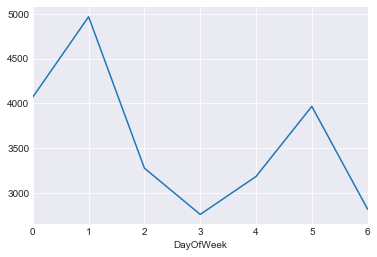

In [47]:
Num_unique_dev=df_dev.groupby('DayOfWeek').nunique()['deviceId'].plot()

In [15]:
g=df_dev.groupby('hour').nunique()['deviceId']

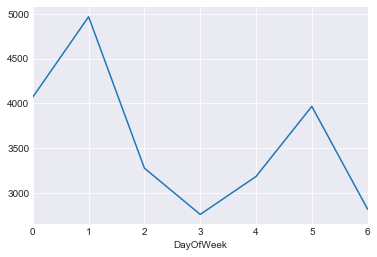

In [45]:
g2.plot()

AttributeError: 'FacetGrid' object has no attribute 'plot'

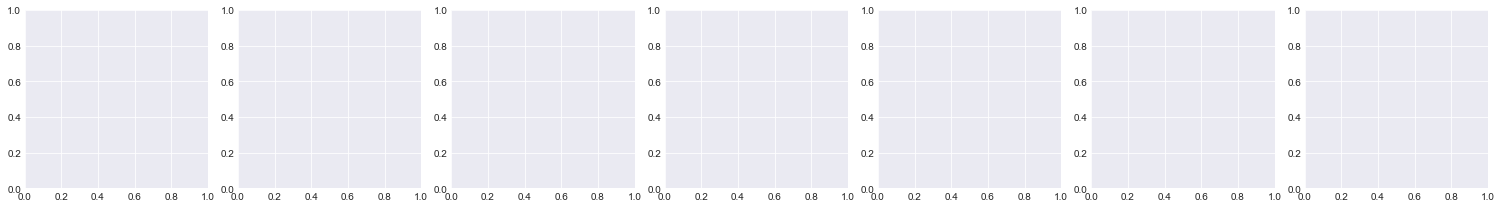

In [38]:
g=sns.FacetGrid(df_dev,col='DayOfWeek')
g.map(plt.scatter, "total_bill", "tip").add_legend()

1. Passanti: Contare quante volte è visto, e il delta tra tempi, con frequenza:
        -Codice 1234 è dipendente se sta nel negozio 90% del giorno, e rilevato ogni 30 secondi
        -Se passante, lo vediamo 1 o 2 volte al giorno per poco tempo (qualche secondo)
        -Verificare se wifi attivo di notte? (ore notturne) Nel caso, sono tutti passanti. Si aperto anche di notte! Analizzare Giorno e Notte.
        -Detettare stampanti e Bancomat e allarmi: visti anche di notte, sempre
        -Problema: negozio di fianco o gente che vive sopra
        -Passanti SEMPRE visti per POCO tempo
        
        